In [3]:
from tqdm import tqdm_notebook

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import mne

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from pylab import rcParams


In [9]:
name = "00010418_s012_t002"
path = "/tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t002.edf"

In [10]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)

In [11]:
edf = mne.io.read_raw_edf("/tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t001.edf", preload=True)

Extracting EDF parameters from /tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 586999  =      0.000 ...  2347.996 secs...


In [12]:
edf.filter(2, 60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 413 samples (1.652 sec)



<RawEDF | 00010418_s012_t001.edf, 30 x 587000 (2348.0 s), ~134.4 MB, data loaded>

# Full picture of a seizure

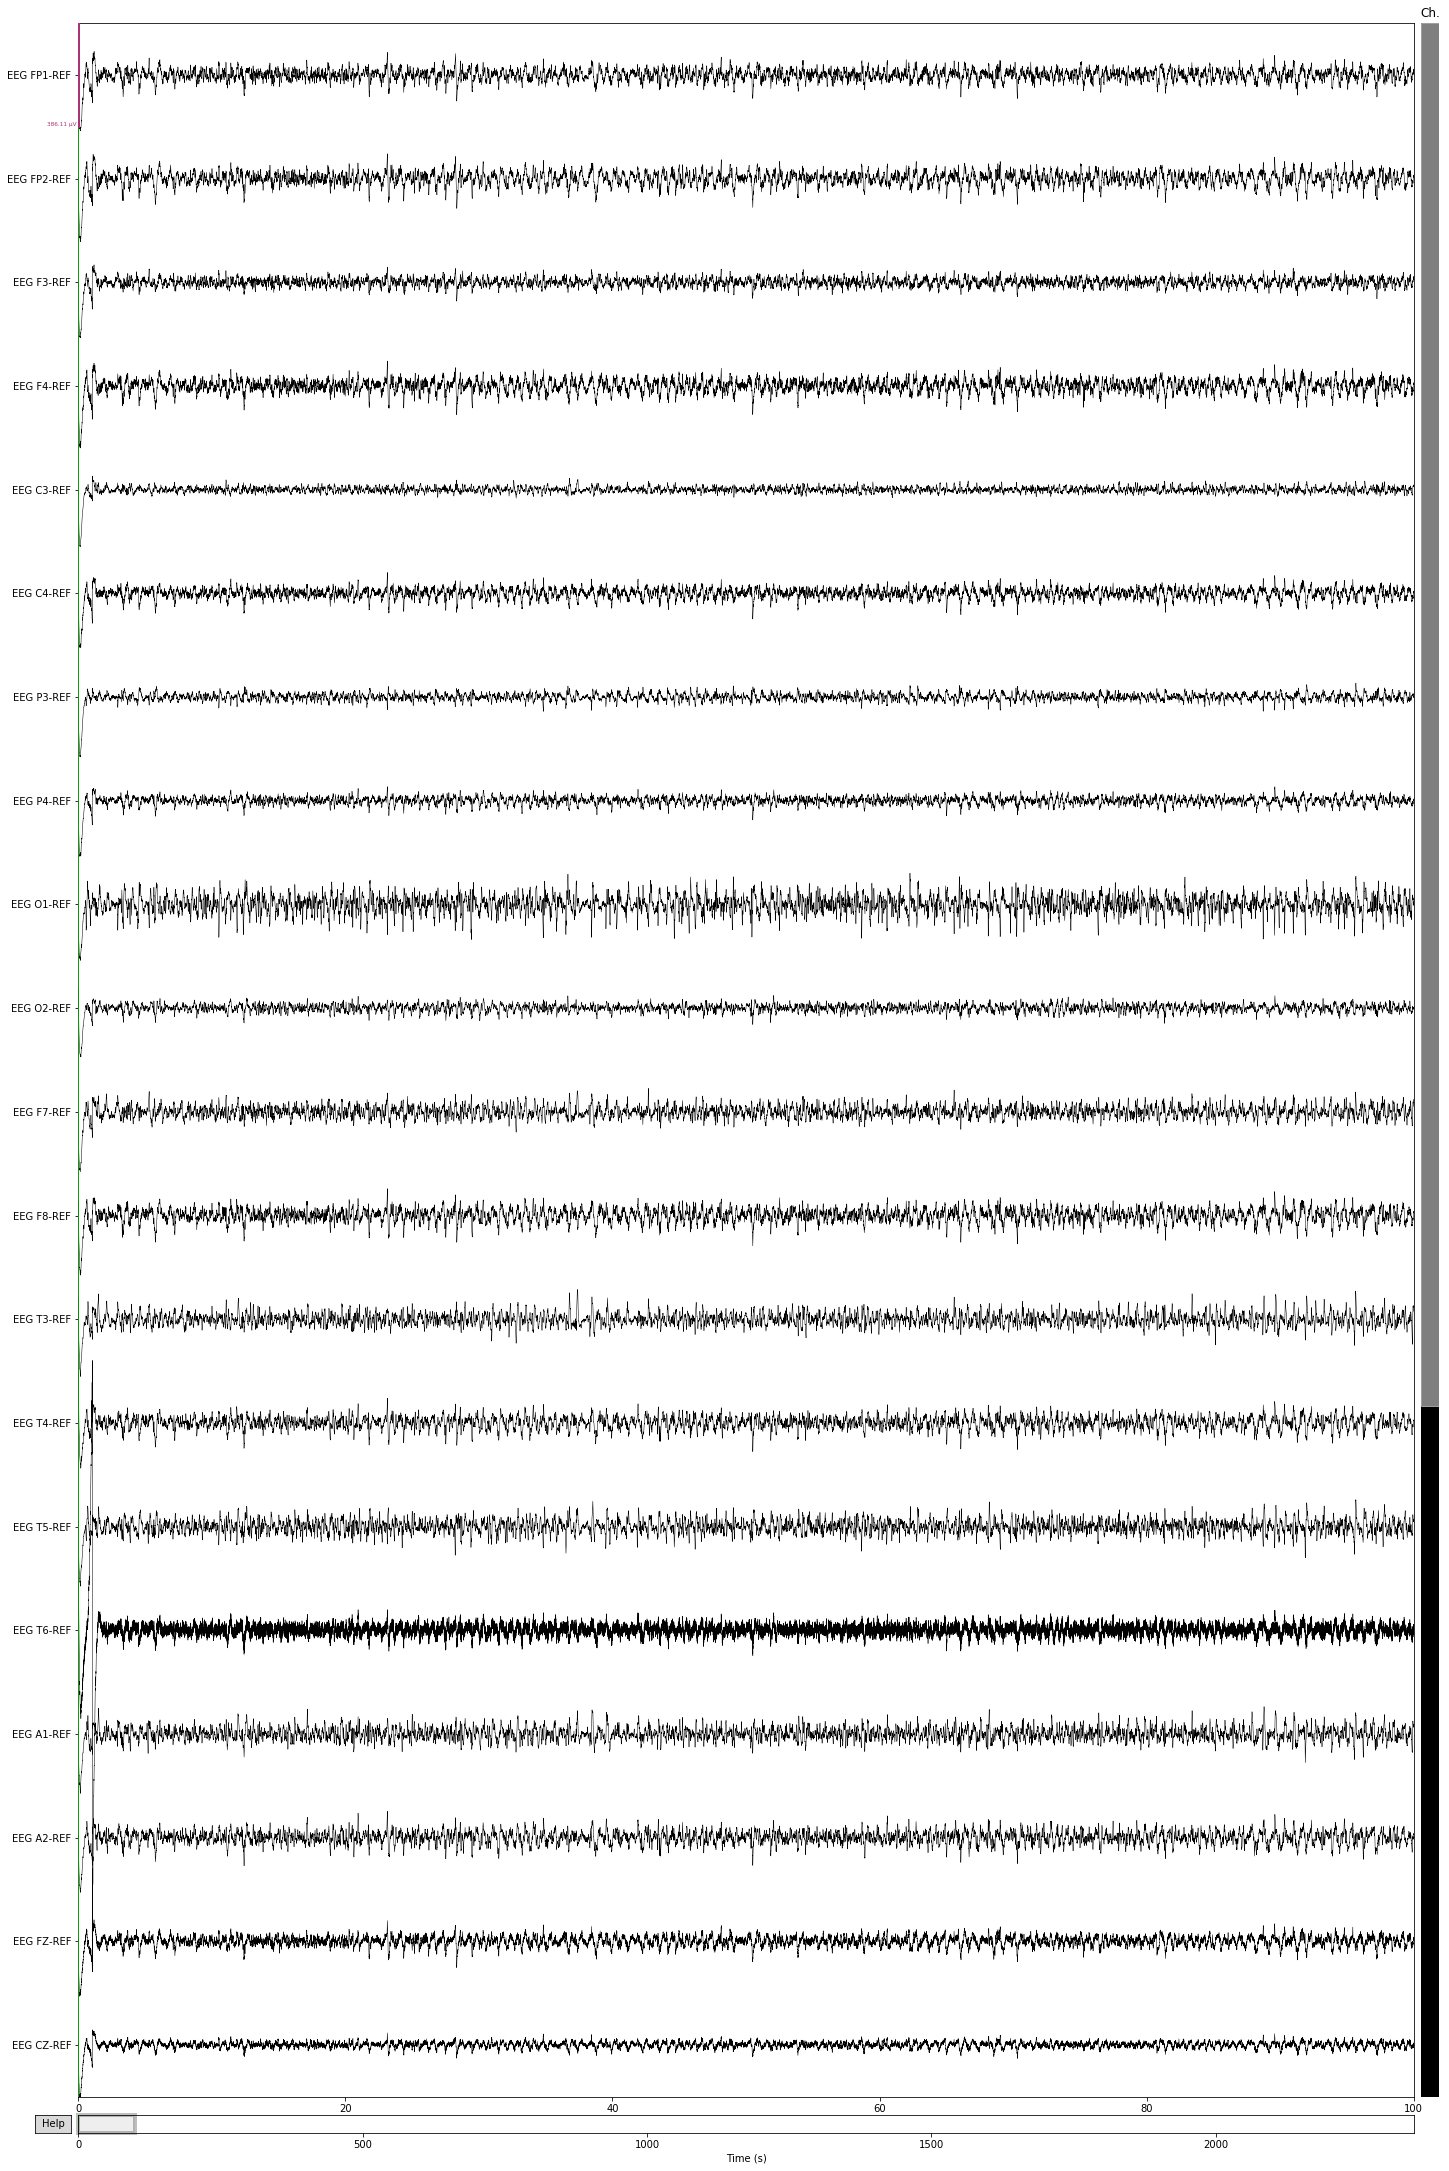

In [13]:
rcParams['figure.figsize'] = 20, 30
mne.viz.plot_raw(
    edf, 
    start=0, 
    duration=100, 
    show=False, 
    scalings=np.percentile(np.abs(edf[0:10000][0]), 99.99)
)
plt.show()

# Electrodes positions

# FFT and DWT - why do they matter

In [14]:
window_size = 250
step_size = window_size // 10

In [48]:
def get_fourier_transform(data):
    global window_size, step_size
    frequencies = []
    for window in tqdm_notebook(range(0, data.shape[0] - window_size, step_size)):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
        frequencies.append(frequency_values)
    return np.stack(frequencies)

In [49]:
channels = [c for c in edf.ch_names if "EEG" in c]

In [50]:
edf_picks = mne.pick_channels(edf.ch_names, channels)

In [70]:
data, _ = edf[edf_picks, :]

In [71]:
data.shape

(26, 587000)

In [81]:
frequencies = get_fourier_transform(data.T)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [82]:
frequencies = frequencies.reshape(frequencies.shape[0], -1)

In [84]:
frequencies.shape

(23470, 3250)

In [61]:
# frequencies_one = frequencies

In [21]:
# frequencies_one = frequencies.copy()

In [112]:
events = train_df[train_df["file"] == name]

In [113]:
normalized_frequencies = frequencies / frequencies.mean(axis=0)

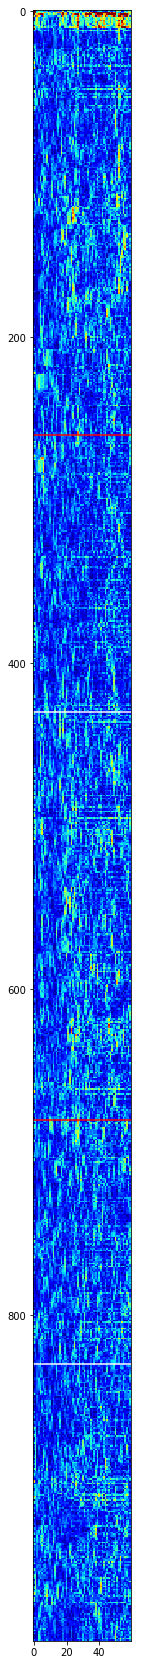

In [117]:
start = 0
end = 100

plt.imshow(normalized_frequencies[start * 10:end * 10, 0:60], cmap="jet", vmin=0, vmax=5)

for _, event in events[(events["start"] > start) & (events["start"] < end)].iterrows():
    color = "red"
    if event["label"] == "bckg":
        color = "white"
    plt.axhline(event["start"] * 10 - start * 10, color=color)

In [54]:
frequencies

(23470, 125)

In [15]:
freqs = np.linspace(0, 60, 0.01)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


# MNE ICA

In [118]:
from mne.preprocessing import ICA

In [119]:
ica = ICA()
ica.fit(edf)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 30 components
Fitting ICA took 35.0s.


<ICA  |  raw data decomposition, fit (fastica): 587000 samples, 30 components, channels used: "eeg">

In [120]:
ica_eeg = ica.get_sources(edf)

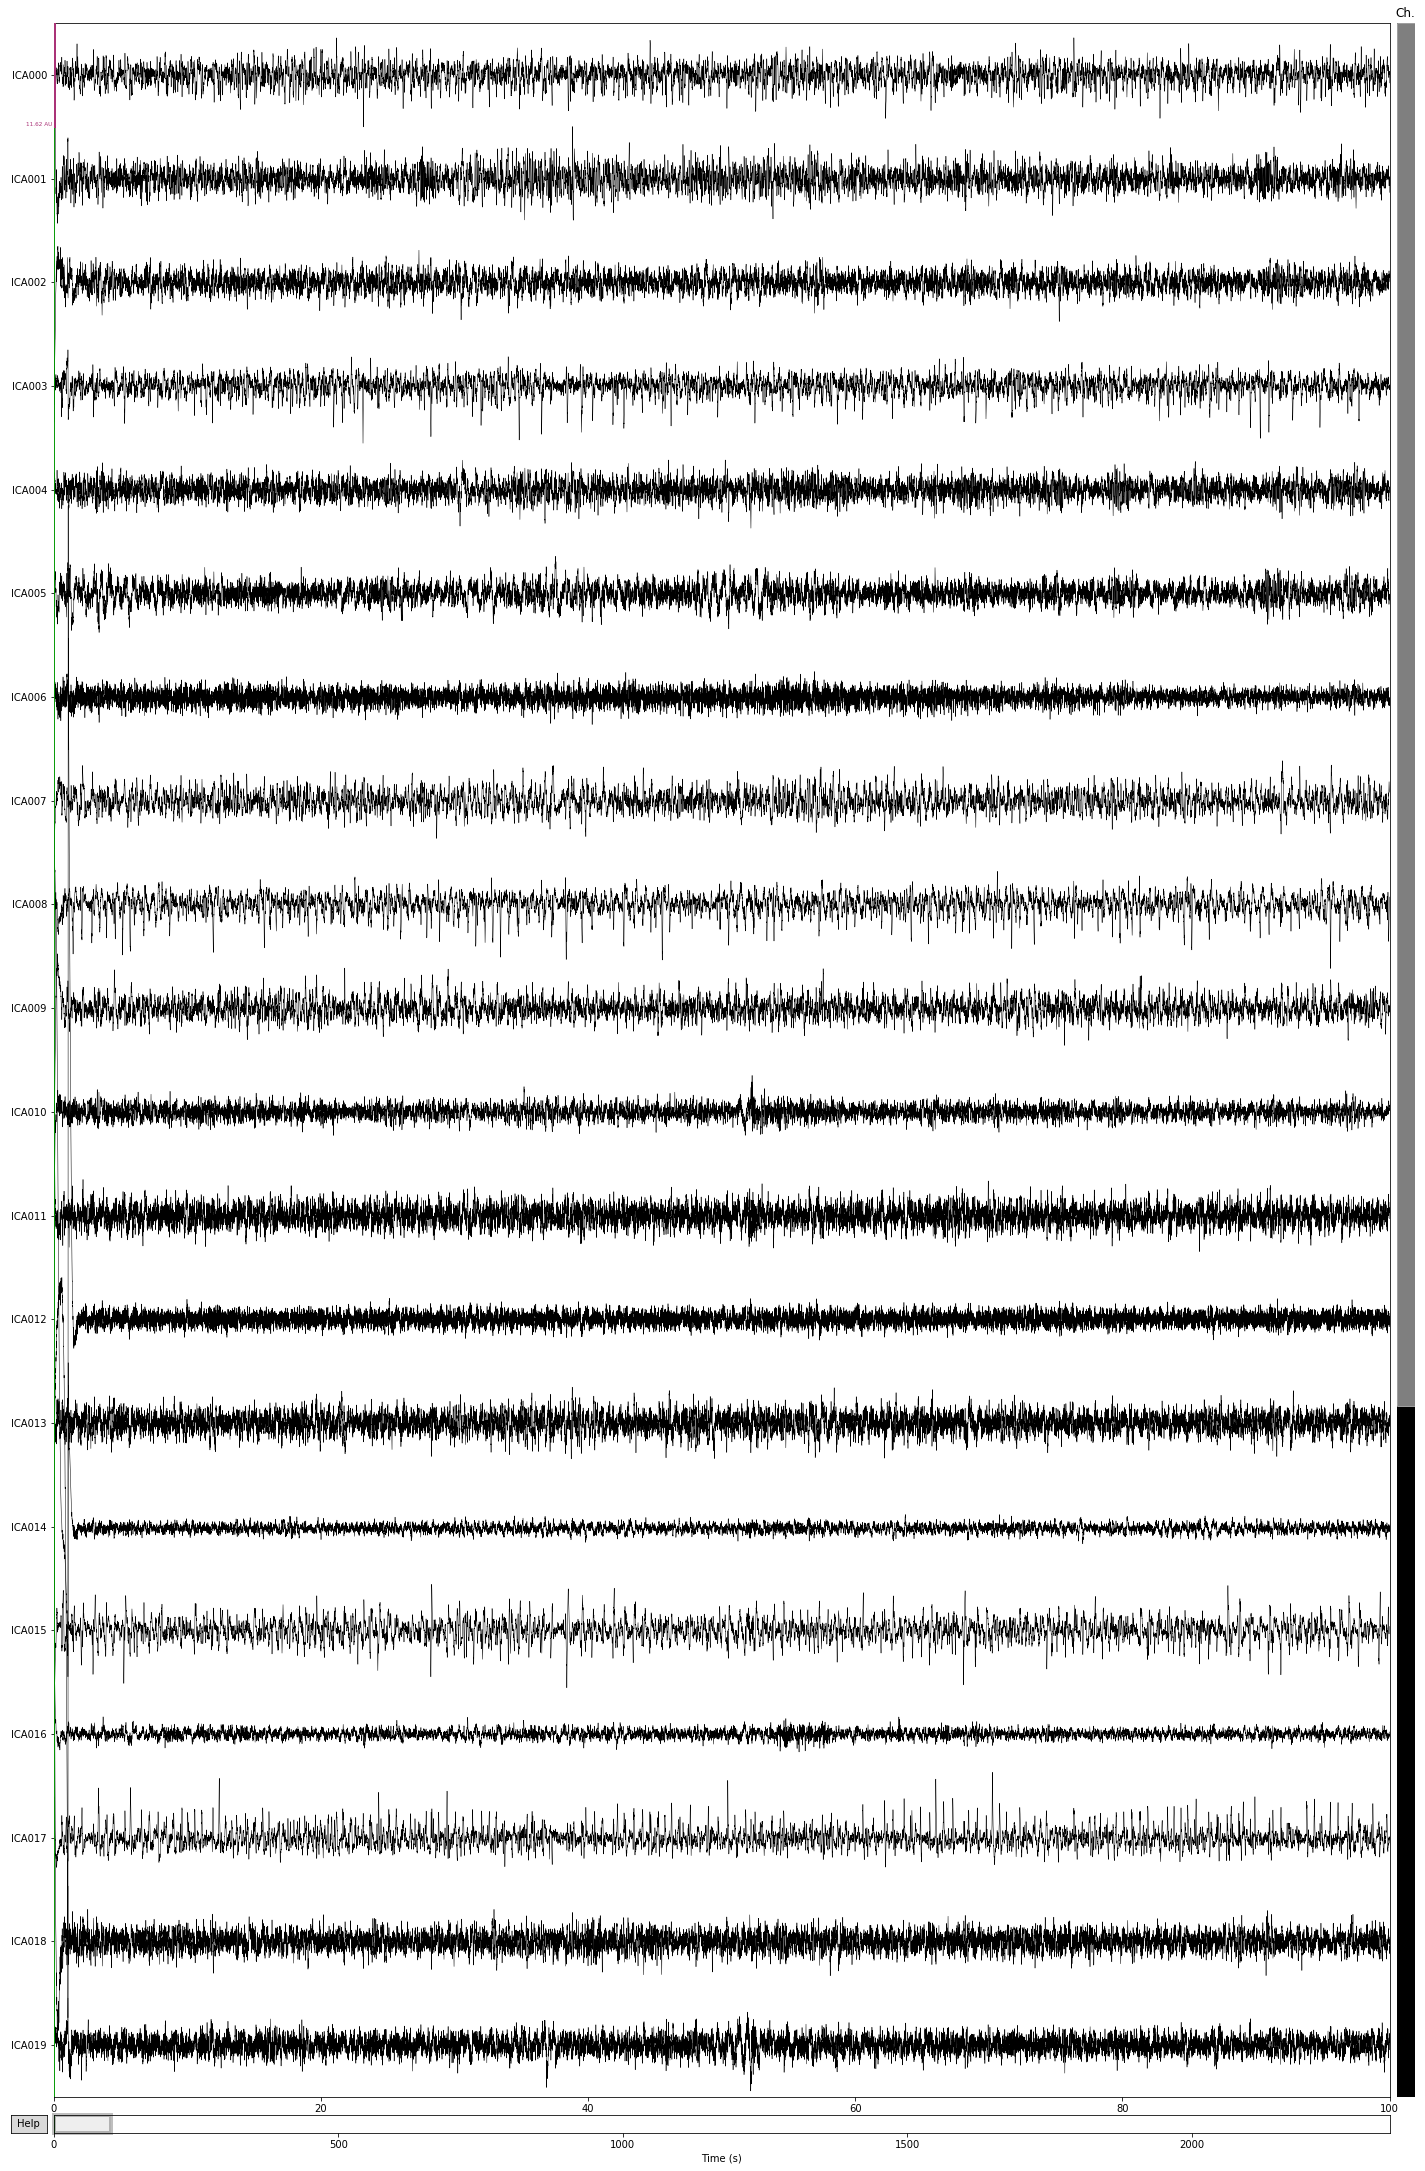

In [122]:
mne.viz.plot_raw(
    ica_eeg, 
    start=0, 
    duration=100, 
    show=False, 
    scalings=np.percentile(np.abs(ica_eeg[0:10000][0]), 99.9)
)
plt.show()